<span>
    <img src="https://www.inesc-id.pt/wp-content/uploads/2019/08/INESC-ID-new-logo_version-02A.png" width="110px" align="right">
    <img src="https://upload.wikimedia.org/wikipedia/pt/e/ed/IST_Logo.png" width="40px" align="right">
</span>
<span>
    <b>Authors:</b> Joana Dimas, Inês Lobo, Samuel Mascarenhas, Diogo Rato and Rui Prada <br/>
    <b>Python version:</b> 3.8.8<br/>
    <b>Scikit-learn version:</b> 0.24.1<br/>
</span>

# Dynamic Identity Model For Agents



In this notebook, the Dynamic Identity Model for Agents is explained and implemented. <b>It is relevant to mention that this notebook is not 100% comprehensive</b>.

## Table of Contents

1. [Introduction](#introduction)
    1. [Architecture](#architecture)
2. [Environment](#environment) 
    1. [Social Context](#socContext)
    2. [Agent](#agent)
    3. [Social Group](#socialGroup)
    4. [Instatiate Environment](#instEnvironment)
3. [Identity Salience Mechanism](#idSalienceMechanism)
    1. [Social Categorization](#socCategorization)
    2. [NormativeFit](#normativeFit)
    3. [ComparativeFit](#comparativeFit)
    4. [Salience](#salience)
    5. [Accessibility Update](#accUpdate)
    6. [Simulation Cycle](#simulation)
    7. [Salience and Accessibility Plots](#plots)
4. [Conclusion](#conclusion)


## Introduction <a id='introduction'></a>

The Dynamic Identity Model for Agents (DIMA) is based on the <b>Social Identity Approach</b>, aiming to provide agents with <b>multi-faceted and context-dependent identities</b>. Its architecture is shown in the figure below. This model has the <b>identity salience mechanism</b> at its center: agents can redefine their identity either as unique individuals (personal identity) or members of a social group (social identity), given their interpretation of the social environment. The active identity (including the salience value, if it corresponds to the salient social identity) will influence agents' decision making.

<h3 align="center">DIMA Architecture</h3> <a id='architecture'></a>

<img src="dima.png" width=60% align="center">

## Environment <a id='environment'></a>

### Social Context <a id='socContext'></a>

The context $Ctx = (A,T)$ is defined by the present agents (who) and the theme (what, where,
when).

The theme $T = \{{c}_{1}, ...,{c}_{n}\}, c \in C$ highlights the characteristics relevant to the current situation. Additionally, each characteristic of the theme is assigned a weight, allowing to prioritize some characteristics over others.

In [1]:
class SocialContext:
    def __init__(self, agentsPresent, theme):
        self.agentsPresent = agentsPresent
        self.theme = theme

### Agent <a id='agent'></a>


As for the model's agents $A = \{{a}_{1}, ...,{a}_{n}\}$, each agent $a=(name_{a}, P_{a},{KB}_{a}), a\in A$ is represented by their name string, a set of personal characteristics, and their knowledge base.

The personal characteristics $P_a = \{({c}_{1}, {v}_{1}), ...,({c}_{n}, {v}_{n})\}, c \in C, v \in [0, 1]$ correspond to the finite set of characteristics that define the agent and their associated values.

The knowledge base $KB_a = \{{sg}_{1}, ..., {sg}_{n}\}, sg \in SG$ is a finite set of social groups known by the agent.


In [2]:
class Agent:
    def __init__(self, name, characteristics, knowledgeBase, scenario = None):
        self.name = name
        self.personalCharacteristics = characteristics
        self.knowledgeBase = knowledgeBase
        self.scenario = scenario
        
        #for the rest of the model calculations 
        self.salientIdentity = None

<h3 id="social-group">Social Group</h3> <a id='socialGroup'></a>

A social group $sg= (name_{sg}, PT_{sg}, acc_{sg}), acc \in [0, 1]$ is represented by a name, its prototypical characteristics, and accessibility value.

The accessibility of a social group $acc_{sg}$ reveals how easy it is for the agent to recall this identity based on prior experiences.

The prototypical characteristics $PT_{sg} = \{({c}_{1}, {v}_{1}), ...,({c}_{n}, {v}_{n})\}, c \in C, v \in [0, 1]$ correspond to the finite set of expected characteristics of a typical member of the group and their associated values.


In [3]:
class SocialGroup:
    def __init__(self, name, characteristics, accessibility, scenario = None):
        self.name = name
        self.characteristics = characteristics
        self.accessibility = accessibility
        
        #for the rest of the model calculations
        self.type = 0; #not present - 0, present - 1
        self.dispersion = None;
        self.fitness = None;
        self.salience = None;
        #for the plots
        self.salienceSteps = []
        self.accessibilitySteps = []

### Instantiate Environment <a id='instEnvironment'></a>

The environment can be specified in two different JSON files.
The following auxiliary function opens and loads the JSON input files. <div id="input-files"></div>

In [4]:
import json
    
def readJSONFile(file):
    data = None
    try:
        # open JSON file
        f = open(file)
        # returns JSON object as a dictionary
        data = json.load(f)
    except:
        print("Problem opening or loading file!")
    return data

#Change files here
agentsFile = "agents_bigdiffgroupsize.json"
print(json.dumps(readJSONFile(agentsFile), indent=2))
contextFile = "context.json"
print(json.dumps(readJSONFile(contextFile), indent=2))


{
  "agents": [
    {
      "name": "Ace",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.92
        },
        {
          "name": "charisma",
          "value": 0.1
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Ben",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.7
        },
        {
          "name": "charisma",
          "value": 0.12
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Cara",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.94
        },
        {
          "name": "charisma",
          "value": 0.15
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Dan",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.8
        },
        {
          "name": "charisma",
          "value": 0.05
        }
      ],
      "knowledgeBase": 

The functions below are used to initialize the agents and the context.

In [5]:
def initAgents(file):
    agents = []
    data = readJSONFile(file)
    if data is not None:
        for a in data['agents']:
            nameA = a['name']
            charA = {}
            kbA = []
            for c in a['characteristics']:
                charA[c['name']] = c['value']
            for sg in a['knowledgeBase']:
                nameSG = sg['name']
                charSG = {}
                accessibility = sg['accessibility']
                for c in sg['characteristics']:
                    charSG[c['name']] = c['value']
                kbA.append(SocialGroup(nameSG, charSG, accessibility))
            agents.append(Agent(nameA, charA, kbA))
    return agents
    
def initContext(file, agents):
    data = readJSONFile(file)
    if data is not None:
        theme = {}
        for t in data['context']['theme']:
            theme[t['name']] = t['weight']

        agentsCtxNames = data['context']['agentsPresent']
        agentsCtx = []
        for a in agents:
            if a.name in agentsCtxNames:
                agentsCtx.append(a)

        return SocialContext(agentsCtx, theme)


Then, we can call the functions above giving as arguments the appropriate input files.

In [6]:
agents = initAgents(agentsFile)
context = initContext(contextFile, agents)

print("There are " + str(len(context.agentsPresent)) + " agents present.")
print("Relevant characteristics are", end = " ")
lenTheme = len(context.theme)
i = 0
for c in context.theme:
    if i == lenTheme - 1: print(c , end = ".")
    else: print(c , end = ", ")
    i += 1

There are 10 agents present.
Relevant characteristics are intelligence, charisma.

## Identity Salience Mechanism <a id="idSalienceMechanism"></a>

Following the environment definition, we can start implementing the agent's identity salience mechanism, as well as define a few variables for the simulation.

In [7]:
#Simulation Variables
numSteps = 100
numRuns = 30
#Plots
plotSymbols = ["o", "v", "H", "*", "X", "d", "P", "s", "D", "p"]
colors = ["red", "blue", "green", "yellow", "aqua", "pink", "brown", "darkorange", "purple", "gray", "olive", "magenta"]
colorsAgents = ["yellow", "aqua", "green", "pink", "brown", "darkorange", "purple", "gray", "olive", "magenta"]
        
#Identity Salience Variables
#Clustering        
thresholdCluster = 0.2
#Normative Fit
thresholdNormative = 0.2
#Comparative Fit
comparativeFitAlpha = 0.5
comparativeFitBeta = 0.5
#Salience
thresholdMinimalSalience = 0.2


In several steps of the identity salience cycle, we have to compute the distance between two points, containing characteristics' values. Then, we created an auxiliary function for that purpose.
We used a <b>weighted euclidean distance</b>, taking into consideration the weights given for each relevant characteristic in the context's theme.

In [8]:
import math
import numpy as np

contextWeights = []
for c in context.theme:
    contextWeights.append(context.theme[c])
    
def distanceWeights(first, second):
    lenWeights = len(contextWeights)
    lDist = abs(np.array(first)-np.array(second))
    auxDist = 0
    #weighted euclidean distance
    for i in range(0, lenWeights):
        auxDist += contextWeights[i] * (lDist[i])**2 
    dist = math.sqrt(auxDist)
    return dist

#Examples
print(distanceWeights([0, 1], [1, 0]))
print(distanceWeights([0.1, 0.8], [0.4, 0.3]))

1.0
0.41231056256176607


### Social Categorization <a id="socCategorization"></a>

In the social categorization phase, the goal is to identify the present social groups. Then, the present agents are grouped into social categories according the context's relevant characteristics.

$SocialCategorization(Ctx, A) = \{sc_1, ..., sc_n\}, a \in A, sc \in SC$

For this step, we used an <b>iterative K-Means</b> algorithm, following a distance threshold heuristic: $\forall a (distance(a, sc_a) \leq tSocialGroup), a \in A, sc \in SC$

In [9]:
from sklearn.cluster import KMeans

def distanceToCentroids(first, second):
    distance = []
    lenFirst = len(first)
    for i in range(0, lenFirst):          
        auxDist = distanceWeights(first[i], second[i])           
        distance.append(auxDist)
    return distance

dataAgents = []
def clustering():
    kMeansCycle = True
    k = 1

    #data to cluster
    dataAgents.clear()
    for a in context.agentsPresent:
        aux = []
        for c in context.theme:
            aux.append(a.personalCharacteristics[c])
        dataAgents.append(aux)

    lenAgents = len(dataAgents)

    #iterative k means
    while kMeansCycle:            
        km = KMeans(n_clusters=k)
        km = km.fit(dataAgents)
        clustersLabels = km.labels_
        clustersCentroids = km.cluster_centers_

        centroidsList = []
        #centroids list
        for i in range(0, lenAgents):
            centroidsList.append(clustersCentroids[clustersLabels[i]])

        #distance of agents to centroid
        distance = distanceToCentroids(dataAgents, centroidsList)

        if any(dist > thresholdCluster for dist in distance):
            k+=1
        else:
            kMeansCycle = False
    
    return (k, clustersLabels, clustersCentroids)
                
clustersCt = clustering()
print(clustersCt)

(2, array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1]), array([[0.85875, 0.145  ],
       [0.17   , 0.9    ]]))


C:\Users\Ines Lobo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In the following cells, we can see the plot with the agents' relevant characteristics and respective clusters.

<b>Attention: </b> The following function was specified for when there are only 2 relevant characteristics in the context. However, more characteristics can be added to the environment by changing the appropriate input files <a href="#input-files">here</a>.

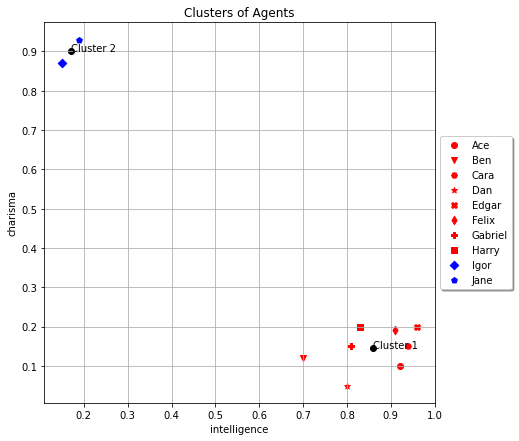

In [10]:
import matplotlib.pyplot as plt

def printClustering():
    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.grid()
        
    lenColorsClusters = len(colors)
    lenSymbolsAgents = len(plotSymbols)

    for i in range(0, clustersCt[0]):
        for j in range(0, len(dataAgents)):
            if(clustersCt[1][j] == i):
                #plotting the agents
                name = context.agentsPresent[j].name
                x = dataAgents[j][0]
                y = dataAgents[j][1]
                symbol = plotSymbols[j%lenSymbolsAgents]
                color = colors[i%lenColorsClusters]
                plt.scatter(x, y, c=color, marker=symbol, label=name)

    #plotting the centroids
    for c in range(0, len(clustersCt[2])):
        x = clustersCt[2][c][0]
        y = clustersCt[2][c][1]
        plt.scatter(x, y, c='black')
        plt.annotate("Cluster " + str(c+1), (x, y))
    
    plt.title('Clusters of Agents')
    themeKeys = list(context.theme)  
    plt.xlabel(themeKeys[0])
    plt.ylabel(themeKeys[1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)           
    plt.show()

printClustering()

### Normative Fit <a id="normativeFit"></a>

During the normative fit, each agent will attempt to identify the previous groups by verifying if they are present in their knowledge base or if they need to be added as a new social group.
The centroids of each group/cluster and the prototypical characteristics of each social group known by the agent are compared. If this difference is below a given threshold, the cluster is identified as an instance of the social group. Otherwise, the cluster is added as a new social group.

<div id="norm-fit"></div>
We also computed the $dispersion$ of each cluster during this step to be used in the comparative fit step. The dispersion of a group is related to their intra-group differences and it can be computed by the <b>normalized average of absolute differences between each group member and the group's centroid</b>.

$dispersion_{(sg_{i})} = \frac{\sum\limits_{x=1}^{n} \left|P_{a_x} - PT_{sg_{i}} \right|}{n}, n = |A_{sg_i}|, a_{x} \in A_{sg_i}$

In [11]:
def dispersion(sg, agentsGroup): 
    diff = []
    #only calculate dispersion with agents that belong to the group
    for j in agentsGroup:
        diff.append(distanceWeights(dataAgents[j], sg))
    return np.mean(diff, axis=0)/thresholdNormative

Additionally, for clusters that are not present in the knowledge base, their accessibility needs to be initialized as well.
The initial accessibility of a group is higher if the difference between an agent's values and the group's centroid is smaller. Then, accessibility should be initialized with the <b>complement value of the agent-group difference</b>.

$acc _{(sg_i)_{t=0}} = 1 - \left|P_{a_{x}} - PT_{(sg_{i})} \right|, a_{x} \in A$

In [12]:
def normalizeAccessibility(a):
    sumAcc = 0
    for sg in a.knowledgeBase:
        sumAcc += sg.accessibility**2
    normAcc = np.sqrt(sumAcc)
    for sg in a.knowledgeBase:
        sg.accessibility /= normAcc

def initAccessibility(idxA, sg):
    return 1 - distanceWeights(dataAgents[idxA], sg)

Finally, we can define the normative fit.

In [13]:
def normativeFit(a, idxA):
    #verify if the characteristics of the social groups in the KB match with the context's theme
    matchSGs = []
    for sg in a.knowledgeBase:
        match = True
        centroidSG = []
        for t in context.theme:
            if t not in sg.characteristics:
                match = False
                sg.type = 0
            else:
                centroidSG.append(sg.characteristics[t])
        if match:
            matchSGs.append([sg, centroidSG])
            
    
    #distance centroids clusters to centroids social groups matching context KB
    for i, c in enumerate(clustersCt[2]):
        agentsGroup = []
        for j, l in enumerate(clustersCt[1]):
            if l == i:
                agentsGroup.append(j)
                
        #get dispersion of cluster
        dispersionGroup = dispersion(c, agentsGroup)
        #get initial accessibility of cluster
        accessibilityGroup = initAccessibility(idxA, c)

        knownSG = False
        for m in matchSGs:
            #distance between cluster centroid and kb sg centroid
            distClusterKB = distanceWeights(m[1], c)
            #compare to threshold
            if distClusterKB < thresholdNormative:
                knownSG = True
                m[0].dispersion = dispersionGroup
                m[0].type = 1
                if m[0].accessibility is None:
                    m[0].accessibility = accessibilityGroup
        #new social group in the KB
        if not knownSG: 
            name = "Group " + (str(len(a.knowledgeBase) + 1))
            newSGchar = {}
            for idx, t in enumerate(context.theme):
                newSGchar[t] = c[idx]
            newSG = SocialGroup(name, newSGchar, accessibilityGroup)
            newSG.dispersion = dispersionGroup
            newSG.type = 1
            a.knowledgeBase.append(newSG)
    normalizeAccessibility(a)

print("Before Normative Fit")
print(agents[0].knowledgeBase)
print("After Normative Fit")
normativeFit(agents[0], 0)
print(agents[0].knowledgeBase)


Before Normative Fit
[]
After Normative Fit
[<__main__.SocialGroup object at 0x0000026A1CBC1AF0>, <__main__.SocialGroup object at 0x0000026A1CBC1B20>]


### Comparative Fit <a id="comparativeFit"></a>

In the comparative fit step, the fitness of each relevant social identity $si_i \in SI_a$ in the agent's knowledge base is determined by the distance between groups <b>(inter-group differences)</b> and their dispersion <b>(intra-group differences)</b>:

${fit}_{si_i}= f(distance_{(sg_{in}, sg_{out})}, dispersion_{(sg_{in})}, dispersion_{(sg_{out})}) = 
\alpha (distance_{(sg_{in},sg_{out})}) + (1 - \alpha)\left[\beta (1 - dispersion_{(sg_{in})}) + (1 - \beta)(dispersion_{(sg_{out})})\right]$

The dispersion formula is described <a href="#norm-fit">here</a>. The distance is computed by the <b>normalized difference between the in-group centroids and the out-group centroids</b>.
Social groups with <b>higher fitness</b> have <b>less clustering dispersion</b> and <b>higher distance</b> from the other social groups.

$distance_{(sg_{in},sg_{out})} = \left|PT_{sg_{out}} - PT_{sg_{in}} \right|$

In [14]:
#we are assuming that there can be more than one out-group
def dispersionCF(sg): 
    dispersion = []
    for i in sg:
        dispersion.append(i.dispersion)
    return np.mean(dispersion, axis=0)

def distanceCF(inGroup, outGroup):
    centroidIn = []
    for sg in inGroup:
        ct = []
        for c in sg.characteristics:
            ct.append(sg.characteristics[c])
        centroidIn.append(ct)
    centroidOut = []
    for sg in outGroup:
        ct = []
        for c in sg.characteristics:
            ct.append(sg.characteristics[c])
        centroidOut.append(ct)
        
    meanCentroidIn = np.mean(centroidIn, axis=0)
    meanCentroidOut = np.mean(centroidOut, axis=0)
    return distanceWeights(meanCentroidIn, meanCentroidOut)

def comparativeFit(a):
    presentGroups = []
    #Get present groups only
    for sg in a.knowledgeBase:
        if sg.type == 1:
            presentGroups.append(sg)
            
    #there is more than one social group
    if (len(presentGroups)) > 1:
        for idx, g in enumerate(presentGroups):
            inGroup = [g]
            outGroup = [x for i,x in enumerate(presentGroups) if i!=idx]    
            #compute distance between in group and outgroup(s)
            distanceBetweenGroups = distanceCF(inGroup, outGroup) #in case theres more than one outgroup (or ingroup)
            #compute dispersion in group and out group(s)
            dispersionInGroup = dispersionCF(inGroup)
            dispersionOutGroup = dispersionCF(outGroup)
            #compute fitness
            fitness = comparativeFitAlpha * distanceBetweenGroups + ((1 - comparativeFitAlpha) * (comparativeFitBeta * (1 - dispersionInGroup) + (1 - comparativeFitBeta) * dispersionOutGroup)) 
            #update fitness for each sg
            g.fitness = fitness
    #only one social group - fitness is 0 - personal identity
    else:
        for g in presentGroups:
            g.fitness = 0
            
comparativeFit(agents[0])
print("Fitness " + agents[0].knowledgeBase[0].name)
print(agents[0].knowledgeBase[0].fitness)
print("Fitness " + agents[0].knowledgeBase[1].name)
print(agents[0].knowledgeBase[1].fitness)


Fitness Group 1
0.5631609793429289
Fitness Group 2
0.6594736318195866


### Salience <a id="salience"></a>

During these steps, the salience of each relevant identity in the agent's knowledge base needs to be computed given its fitness and accessibility values.

$Salience(a, Ctx, SC): salience_{SI_a} = \forall {si}({salience}_{si}), {si} \in SI_a, a \in A$

${salience}_{si_i} = f ({fit}_{{si}_i}, {acc}_{{si}_i}) = fit_{si_{i}} \times acc_{si_{i}}$

The <b>salient social identity</b> for each agent is the one with the <b>maximum value of salience</b>.

$SalientSocialIdentity(a, Ctx): {salSocialIdentity}_a = max(salience_{SI_a}), a \in A$

When making <b>actions and decisions</b>, agents will use their <b>personal identity</b> (if there is only one social group in the environment or if the maximum value of salience of their salient social identity is lower or equal to the threshold of the minimum salience), or their <b>salient social identity</b>. Agents will then redefine their self-concept based on this active identity, without ever losing their personal characteristics.

$ActiveIdentity(a, SC): {activeIdentity}_a =\begin{cases}
{salSocialIdentity}_a\text{,} & \text{if $C1$ is $true$, $a \in A$} \\
{personalIdentity}_a\text{,} & \text{otherwise, $a \in A$} \\
\end{cases}$

$\text{$C1$: }|SC| > 1 \text{ and } salience_{salSocialIdentity_a} > tSalience$


In [15]:
def salienceSocialGroup(a):
    for sg in a.knowledgeBase:
        if sg.type == 1:
            fitness = sg.fitness
            accessibility = sg.accessibility
            #compute salience 
            salience = fitness * accessibility
            #update salience for each sg
            sg.salience = salience

def salientActiveIdentity(a, idxAgent):
    salienceVal = 0
    identity = None
    identityName = "personal"
    presentGroups = []
    #Get present groups only
    for sg in a.knowledgeBase:
        if sg.type == 1:
            presentGroups.append(sg)
    
    #more than one social group - social identity
    if len(presentGroups) > 1:
        #find social identity with highest salience
        for sg in presentGroups:
            auxVal = sg.salience
            if  auxVal > salienceVal:
                salienceVal = auxVal
                identity = sg
        if salienceVal > thresholdMinimalSalience: #only updating salient social identity again if its salience is above or equal to threshold        
            a.salientIdentity = identity
        else:
            a.salientIdentity = None
    else:
        a.salientIdentity = None
        
salienceSocialGroup(agents[0])
salientActiveIdentity(agents[0], 0)
if (agents[0].salientIdentity != None):
    print("Salient Identity")
    print(agents[0].salientIdentity.name)
    print("Salience")
    print(agents[0].salientIdentity.salience)


Salient Identity
Group 1
Salience
0.5479380198021154


### Accessibility Update <a id="accUpdate"></a>


After performing an action or decision using a specific salient identity, each agent will update its accessibility. Then, the new accessibility value of an identity will be computed according to the previous accessibility and respective salience, being this function like a <b>reinforcement mechanism</b>. 

$acc_{(salSocialIdentity_a)_{t+1}} = f(acc_{(salSocialIdentity_a)_{t}}, salience_{(salSocialIdentity_a)_{t}}) = acc_{(salSocialIdentity_a)_{t}} + salience_{(salSocialIdentity_a)_{t}}$
    
In this stage, the accessibility values of all identities present in an agent's knowledge base must be normalized as well, so that when one identity's accessibility increases, all the others suffer a decay.
This <b>update function can be altered depending on the scenarios</b> tested with the model.

In [16]:
def updateAccessibility(a, learningRate = 0.01):
    sid = a.salientIdentity    
    if sid is not None:
        prevAccessibility = sid.accessibility
        newAccessibility = prevAccessibility + sid.salience * learningRate
        sid.accessibility = newAccessibility
    normalizeAccessibility(a)
        
print("Previous accessibility")
print(agents[0].knowledgeBase[0].accessibility)
print(agents[0].knowledgeBase[1].accessibility)
updateAccessibility(agents[0])
print("New accessibility")
print(agents[0].knowledgeBase[0].accessibility)
print(agents[0].knowledgeBase[1].accessibility)

Previous accessibility
0.9729687245757423
0.2309369199531622
New accessibility
0.9732586294930159
0.2297120809129905


### Simulation Cycle <a id="simulation"></a>

The following auxiliary functions are required for the plots.

In [17]:
def listGraphics(a, s):
    for sg in a.knowledgeBase:
        if sg.type == 1:
            salience = sg.salience if sg.salience is not None else 0
            accessibility = sg.accessibility if sg.accessibility is not None else 0
            if sg.salienceSteps == []:
                sg.salienceSteps = [0] * numSteps
            if sg.accessibilitySteps == []:
                sg.accessibilitySteps = [0] * numSteps
            sg.salienceSteps[s] += salience
            sg.accessibilitySteps[s] += accessibility
        
def clearSim():
    for a in context.agentsPresent:
        for sg in a.knowledgeBase:
            if sg.type == 1:
                sg.fitness = None
                sg.accessibility = None
                sg.salience = None


The simulation cycle is implemented below and follows this order:

$SC \longleftarrow SocialCategorization(Ctx, A)$<br>
for $r \in \{1, numRuns\}$ do
> for $s \in \{1, numSteps\}$ do
>> for $a \in A$ do
>>> $Salience(a, Ctx, SC)$<br>
>>> $SalientSocialIdentity(a, Ctx)$<br>
>>> $ActiveIdentity(a, SC)$<br>
>>> $Action(a, Ctx)$<br>
>>> $AccessibilityUpdate(a)$<br>


In [18]:
#Restarting the simulation
agents = initAgents(agentsFile)
context = initContext(contextFile, agents)

def cycle():
    global clustersCt
    clustersCt = clustering()
    #Run simulation
    for r in range(0, numRuns):
        for s in range(0, numSteps):
            #For each agent
            for idxAgent, a in enumerate(context.agentsPresent):
                normativeFit(a, idxAgent)
                comparativeFit(a)
                salienceSocialGroup(a)
                salientActiveIdentity(a, idxAgent)
                listGraphics(a, s)
                #call scenario move here
                updateAccessibility(a)
        clearSim()
        print("simulation " + str(r))
cycle()

C:\Users\Ines Lobo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 20
simulation 21
simulation 22
simulation 23
simulation 24
simulation 25
simulation 26
simulation 27
simulation 28
simulation 29


### Salience and Accessibility Plots <a id="plots"></a>

The following plots show how the salience and accessibility of each identity (present in each agent's knowledge base) vary throughout the simulation.

Salience Plots


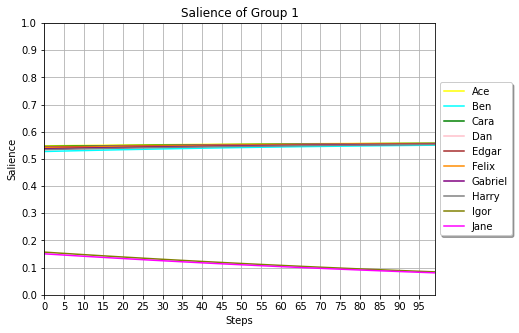

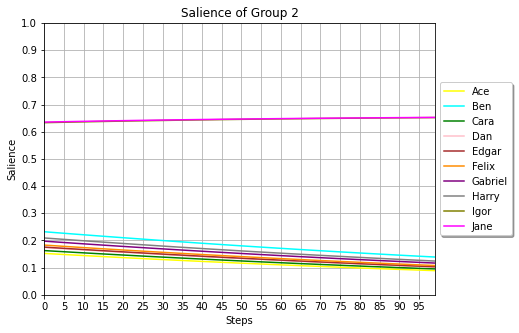

Accessibility Plots


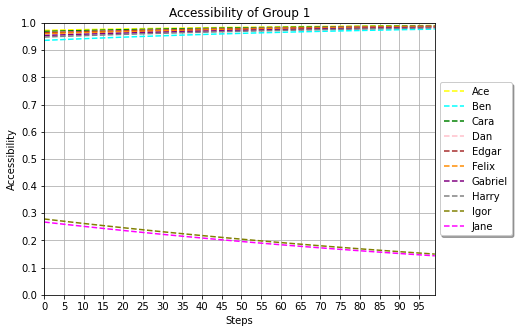

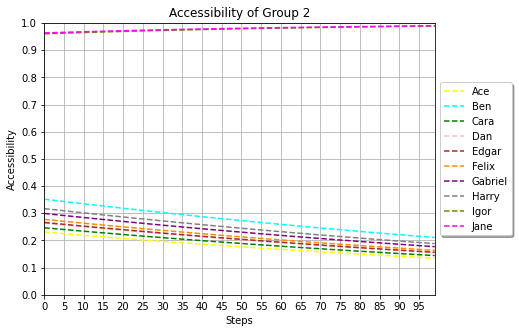

In [19]:
def showSalienceAccessibilityPlots(salience=True):
    numGroups = len(clustersCt[2])
    lenColors = len(colorsAgents)
    for j in range(0, numGroups):
        fig = plt.figure(figsize = (7,5))
        ax = fig.add_subplot(1, 1, 1)
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))
        ax.grid()     
        for i, a in enumerate(context.agentsPresent):
            #plot - scale axis
            sg = a.knowledgeBase[j]
            salienceSims = [x / numRuns for x in sg.salienceSteps]
            accessibilitySims = [x / numRuns for x in sg.accessibilitySteps] 
            colorPlot = colorsAgents[i%lenColors]
            if salience:
                plt.plot(salienceSims, color=colorPlot, label=a.name)
            else:
                plt.plot(accessibilitySims,'--', color=colorPlot, label=a.name)
        if salience:
            plt.title('Salience of Group ' + str(j+1))
        else:
            plt.title('Accessibility of Group ' + str(j+1))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
        plt.xlim(0, numSteps-1) 
        plt.ylim(0, 1)
        plt.xlabel("Steps")
        if salience:
            plt.ylabel("Salience")
        else:
            plt.ylabel("Accessibility")                
        plt.show()

print("Salience Plots")
showSalienceAccessibilityPlots(True)
print("Accessibility Plots")
showSalienceAccessibilityPlots(False)


## Conclusion <a id="conclusion"></a>

In this notebook, we presented the Dynamic Identity Model for Agents, a model grounded on the Social Identity Approach. We provided an overview of the model formalization, as well as a simple example of a simulation. We created another scenario using DIMA, that is available as an additional notebook on GitHub (TODO).

For any questions, please feel free to contact us using this email: ines.lobo@tecnico.ulisboa.pt